In [2]:
#Create references to important directories we will use over and over
import os, sys

current_dir = os.getcwd()
print(current_dir)
LESSON_HOME_DIR = current_dir

path = current_dir+"/data"#+"/Users/alyshareinard/Documents/python/DL_CMEs/data/2014/"
DATA_HOME_DIR=path

/Users/alyshareinard/Documents/python/DL_CMEs/CMEvsnoCME


In [3]:
#Allow relative imports to directories above lesson1/
sys.path.insert(1, os.path.join(sys.path[0], '..'))

#import modules
from utils import *
from vgg16 import Vgg16

#Instantiate plotting tool
#In Jupyter notebooks, you will need to run this command before doing any plotting
%matplotlib inline


Using Theano backend.


## Action Plan
1. Create Validation and Sample sets
2. Rearrange image files into their respective directories 
3. Finetune and Train model
4. Generate predictions
5. Validate predictions
6. Submit predictions to Kaggle

## Create validation set and sample

In [4]:
#Create directories
%cd $DATA_HOME_DIR
%mkdir valid
%mkdir results
%mkdir -p sample/train
%mkdir -p sample/test
%mkdir -p sample/valid
%mkdir -p sample/results
%mkdir -p test/unknown

/Users/alyshareinard/Documents/python/DL_CMEs/CMEvsnoCME/data
mkdir: valid: File exists
mkdir: results: File exists


In [5]:
%cd $DATA_HOME_DIR/train

/Users/alyshareinard/Documents/python/DL_CMEs/CMEvsnoCME/data/train


## Rearrange image files into their respective directories

In [6]:
# Create single 'unknown' class for test set
%cd $DATA_HOME_DIR/test
%mv *.png unknown/

/Users/alyshareinard/Documents/python/DL_CMEs/CMEvsnoCME/data/test
mv: rename *.png to unknown/*.png: No such file or directory


## Finetuning and Training

In [7]:
%cd $DATA_HOME_DIR

#Set path to sample/ path if desired
path = DATA_HOME_DIR + '/' #'/sample/'
test_path = DATA_HOME_DIR + '/test/' #We use all the test data
results_path=DATA_HOME_DIR + '/results/'
train_path=path + '/train/'
valid_path=path + '/valid/'

/Users/alyshareinard/Documents/python/DL_CMEs/CMEvsnoCME/data


In [8]:
#import Vgg16 helper class
vgg = Vgg16()

In [9]:
#Set constants. You can experiment with no_of_epochs to improve the model
batch_size=64
no_of_epochs=8

In [10]:
#Finetune the model
batches = vgg.get_batches(train_path, batch_size=batch_size)
val_batches = vgg.get_batches(valid_path, batch_size=batch_size*2)
vgg.finetune(batches)

#Not sure if we set this for all fits
vgg.model.optimizer.lr = 0.001

Found 6969 images belonging to 2 classes.
Found 996 images belonging to 2 classes.


In [ ]:
#Notice we are passing in the validation dataset to the fit() method
#For each epoch we test our model against the validation set
latest_weights_filename = None
for epoch in range(no_of_epochs):
    print("Running epoch: %d" % epoch)
    vgg.fit(batches, val_batches, batch_size, nb_epoch=1)
    latest_weights_filename = 'ft%d.h5' % epoch
    vgg.model.save_weights(results_path+latest_weights_filename)
print("Completed %s fit operations" % no_of_epochs)


Running epoch: 0
Epoch 1/1
 41/109 [==========>...................] - ETA: 1756s - loss: 1.2705 - acc: 0.7534

In [ ]:
vgg.model.optimizer.lr = 0.0001
for epoch in range(no_of_epochs):
    print("Running epoch: %d" % epoch)
    vgg.fit(batches, val_batches, batch_size, nb_epoch=1)
    latest_weights_filename = 'ft%d.h5' % epoch
    vgg.model.save_weights(results_path+latest_weights_filename)
print("Completed %s fit operations" % no_of_epochs)

## Generate Predictions

Let's use our new model to make predictions on the test dataset

In [80]:
batches, preds = vgg.test(test_path, batch_size = batch_size*2)

Found 73 images belonging to 3 classes.


In [81]:
#For every image, vgg.test() generates two probabilities 
#based on how we've ordered the cats/dogs directories.
#It looks like column one is cats and column two is dogs
print(preds[0:5])

filenames = batches.filenames
print(filenames[0:5])

[[ 0.4804  0.5196]
 [ 0.0519  0.9481]
 [ 0.2379  0.7621]
 [ 0.0105  0.9895]
 [ 0.1406  0.8594]]
['CME/2014_01_05_00_00_00_LASCO_C3.png', 'CME/2014_02_18_00_00_00_LASCO_C3.png', 'CME/2014_02_27_12_00_00_LASCO_C3.png', 'CME/2014_03_10_00_00_00_LASCO_C3.png', 'CME/2014_03_16_00_00_00_LASCO_C3.png']


In [61]:
#Save our test results arrays so we can use them again later
save_array(results_path + 'test_preds.dat', preds)
save_array(results_path + 'filenames.dat', filenames)

## Validate Predictions

Keras' *fit()* function conveniently shows us the value of the loss function, and the accuracy, after every epoch ("*epoch*" refers to one full run through all training examples). The most important metrics for us to look at are for the validation set, since we want to check for over-fitting. 

- **Tip**: with our first model we should try to overfit before we start worrying about how to reduce over-fitting - there's no point even thinking about regularization, data augmentation, etc if you're still under-fitting! (We'll be looking at these techniques shortly).

As well as looking at the overall metrics, it's also a good idea to look at examples of each of:
1. A few correct labels at random
2. A few incorrect labels at random
3. The most correct labels of each class (ie those with highest probability that are correct)
4. The most incorrect labels of each class (ie those with highest probability that are incorrect)
5. The most uncertain labels (ie those with probability closest to 0.5).

Let's see what we can learn from these examples. (In general, this is a particularly useful technique for debugging problems in the model. However, since this model is so simple, there may not be too much to learn at this stage.)

Calculate predictions on validation set, so we can find correct and incorrect examples:

In [82]:
vgg.model.load_weights(results_path+latest_weights_filename)

In [83]:
val_batches, probs = vgg.test(valid_path, batch_size = batch_size)

Found 146 images belonging to 2 classes.


In [96]:
filenames = val_batches.filenames
expected_labels = val_batches.classes #0 or 1

#Round our predictions to 0/1 to generate labels
our_predictions = probs[:,0]
print(1-our_predictions[0:5]-0.3)
our_labels = np.round(1-our_predictions-.3)

[ 0.2804  0.4394  0.5448  0.4773  0.5799]


In [97]:
from keras.preprocessing import image

#Helper function to plot images by index in the validation set 
#Plots is a helper function in utils.py
def plots_idx(idx, titles=None):
    plots([image.load_img(valid_path + filenames[i]) for i in idx], titles=titles)
    
#Number of images to view for each visualization task
n_view = 4

Found 122 correct labels


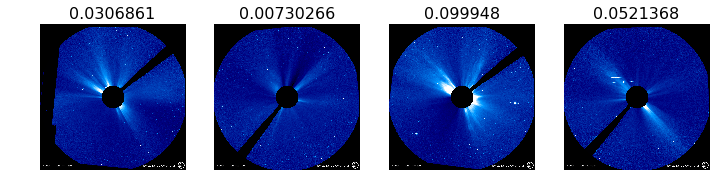

In [98]:
#1. A few correct labels at random
correct = np.where(our_labels==expected_labels)[0]
print("Found %d correct labels" % len(correct))
idx = permutation(correct)[:n_view]
plots_idx(idx, our_predictions[idx])

Found 24 incorrect labels


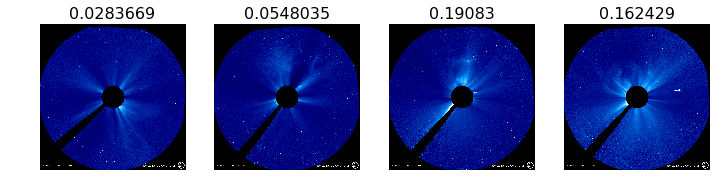

In [99]:
#2. A few incorrect labels at random
incorrect = np.where(our_labels!=expected_labels)[0]
print("Found %d incorrect labels" % len(incorrect))
idx = permutation(incorrect)[:n_view]
plots_idx(idx, our_predictions[idx])

In [1]:
#3a. The images we most confident were cats, and are actually cats
correct_cmes = np.where((our_labels==0) & (our_labels==expected_labels))[0]
print("Found %d confident correct CME labels" % len(correct_cmes))
most_correct_cmes = np.argsort(our_predictions[correct_cmes])[::-1][:n_view]
plots_idx(correct_cmes[most_correct_cmes], our_predictions[correct_cmes][most_correct_cmes])

NameError: name 'np' is not defined

Found 95 confident correct dogs labels


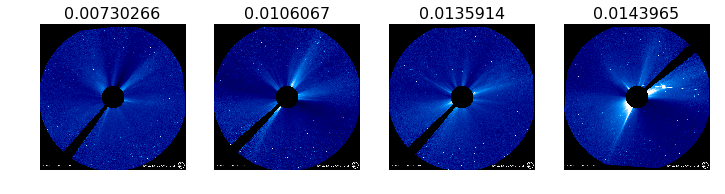

In [101]:
#3b. The images we most confident were dogs, and are actually dogs
correct_quiet = np.where((our_labels==1) & (our_labels==expected_labels))[0]
print("Found %d confident correct non-CME labels" % len(correct_quiet))
most_correct_dogs = np.argsort(our_predictions[correct_quiet])[:n_view]
plots_idx(correct_quiet[most_correct_quiet], our_predictions[correct_quiet][most_correct_quiet])

Found 6 incorrect cats


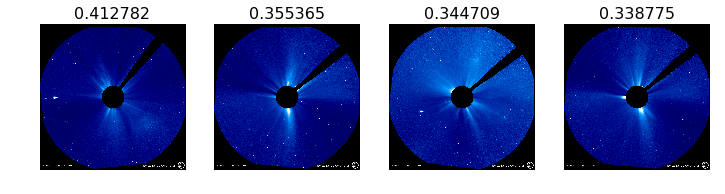

In [102]:
#4a. The images we were most confident were cats, but are actually dogs
incorrect_cmes = np.where((our_labels==0) & (our_labels!=expected_labels))[0]
print("Found %d incorrect cats" % len(incorrect_cmes))
if len(incorrect_cmes):
    most_incorrect_cmes = np.argsort(our_predictions[incorrect_cmes])[::-1][:n_view]
    plots_idx(incorrect_cmes[most_incorrect_cmes], our_predictions[incorrect_cmes][most_incorrect_cmes])

Found 18 incorrect dogs


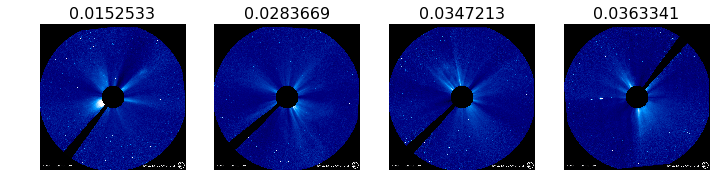

In [103]:
#4b. The images we were most confident were dogs, but are actually cats
incorrect_quiet = np.where((our_labels==1) & (our_labels!=expected_labels))[0]
print("Found %d incorrect dogs" % len(incorrect_dogs))
if len(incorrect_quiet):
    most_incorrect_quiet = np.argsort(our_predictions[incorrect_quiet])[:n_view]
    plots_idx(incorrect_quiet[most_incorrect_quiet], our_predictions[incorrect_quiet][most_incorrect_quiet])

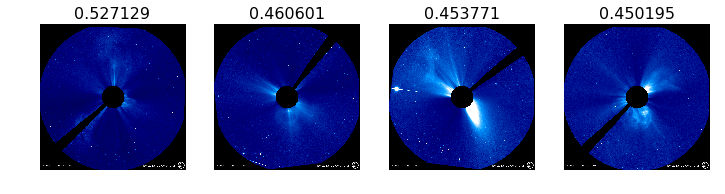

In [104]:
#5. The most uncertain labels (ie those with probability closest to 0.5).
most_uncertain = np.argsort(np.abs(our_predictions-0.5))
plots_idx(most_uncertain[:n_view], our_predictions[most_uncertain])

Perhaps the most common way to analyze the result of a classification model is to use a [confusion matrix](http://www.dataschool.io/simple-guide-to-confusion-matrix-terminology/). Scikit-learn has a convenient function we can use for this purpose:

In [105]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(expected_labels, our_labels)

We can just print out the confusion matrix, or we can show a graphical view (which is mainly useful for dependents with a larger number of categories).

[[27 18]
 [ 6 95]]


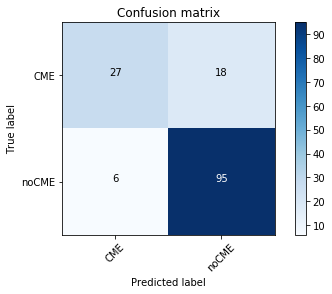

In [106]:
plot_confusion_matrix(cm, val_batches.class_indices)